 * Serving Flask app '__main__'
 * Debug mode: off


C:\Users\Ankita\AppData\Local\Temp\ipykernel_11408\605068147.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  energy_met_df.fillna(method='ffill', inplace=True)
C:\Users\Ankita\AppData\Local\Temp\ipykernel_11408\605068147.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  max_demand_df.fillna(method='ffill', inplace=True)
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Jun/2024 17:32:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Jun/2024 17:32:16] "GET /static/Images/bg3.jpg HTTP/1.1" 304 -
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
127.0.0.1 - - [11/Jun/2024 17:32:54] "POST /forecast HTTP/1.1" 200 -


[0]	validation_0-rmse:7877.61901
[100]	validation_0-rmse:3054.61041
[200]	validation_0-rmse:1392.63515
[300]	validation_0-rmse:907.50969
[400]	validation_0-rmse:791.93065
[500]	validation_0-rmse:751.12869
[599]	validation_0-rmse:725.98607


127.0.0.1 - - [11/Jun/2024 17:33:39] "POST /forecast HTTP/1.1" 200 -


[0]	validation_0-rmse:7877.61901
[100]	validation_0-rmse:3054.61041
[200]	validation_0-rmse:1392.63515
[300]	validation_0-rmse:907.50969
[400]	validation_0-rmse:791.93065
[500]	validation_0-rmse:751.12869
[599]	validation_0-rmse:725.98607


127.0.0.1 - - [11/Jun/2024 17:33:47] "POST /forecast HTTP/1.1" 200 -


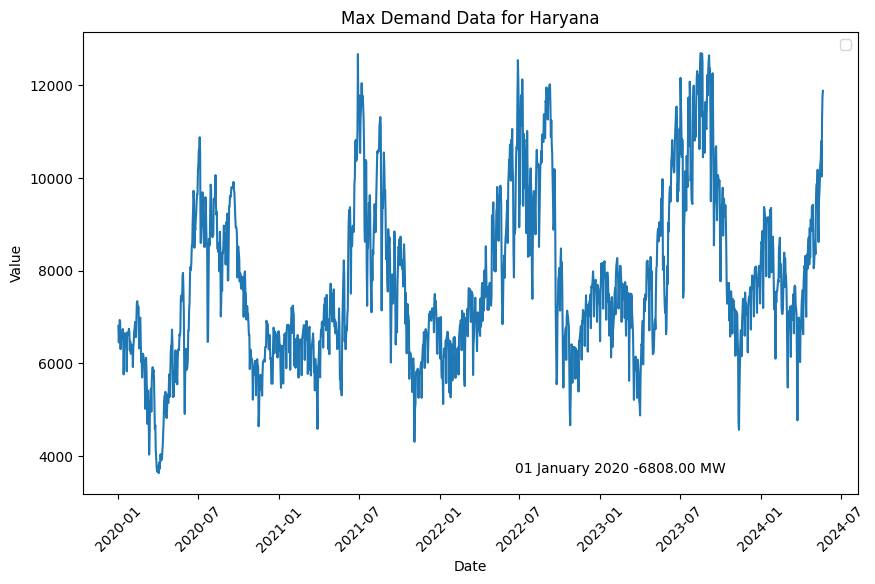

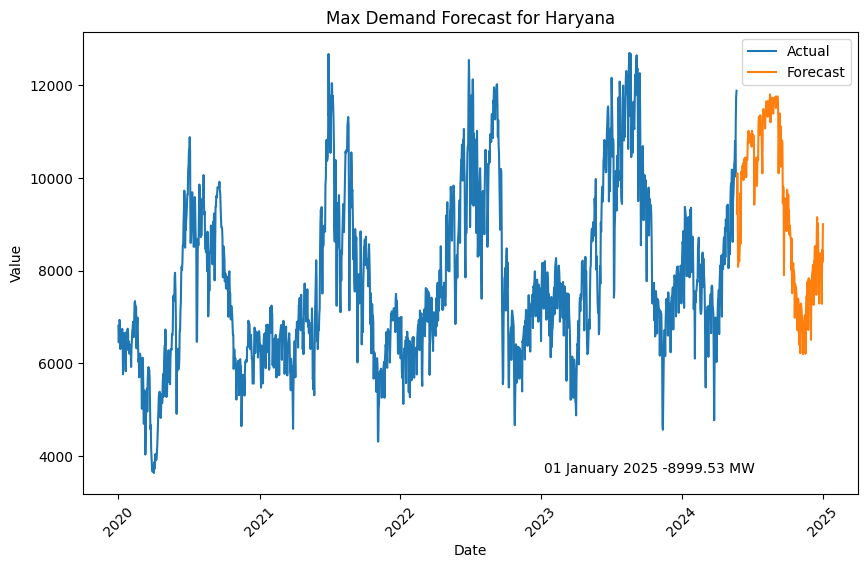

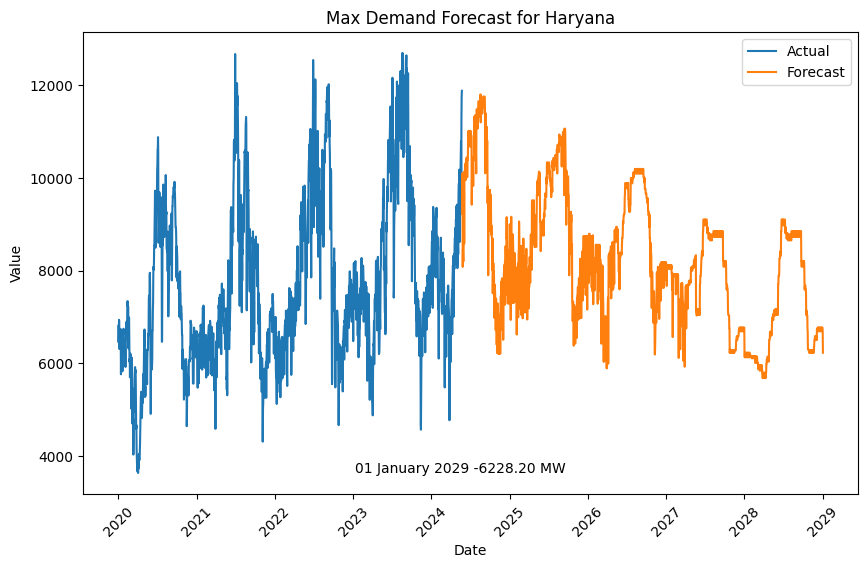

In [3]:
import pandas as pd
from flask import Flask, render_template, request, jsonify
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import io
import base64
import xgboost as xgb
from datetime import datetime

app = Flask(__name__)

# Load data
energy_met_df = pd.read_csv('energy_states_consolidated.csv')
max_demand_df = pd.read_csv('max_states_consolidated.csv')

# Convert the 'Date' column to datetime format
energy_met_df['Date'] = pd.to_datetime(energy_met_df['Date'],format='%d-%m-%y')
max_demand_df['Date'] = pd.to_datetime(max_demand_df['Date'],format='%d-%m-%y')

#Setting the Date column as the index
energy_met_df.set_index('Date', inplace=True)
max_demand_df.set_index('Date', inplace=True)

energy_met_df.sort_index(inplace=True)
max_demand_df.sort_index(inplace=True)

# Handle missing values (e.g., forward fill)
energy_met_df.fillna(method='ffill', inplace=True)
max_demand_df.fillna(method='ffill', inplace=True)

energy_met_trans=energy_met_df.T
max_demand_trans=max_demand_df.T


@app.route('/')
def index():
    states = energy_met_trans.index.unique()  
    return render_template('old.html', states=states)

@app.route('/forecast', methods=['POST'])
def forecast():
    state = request.form['state']
    data_type = request.form['data_type']
    end_date = request.form['end_date']

    if data_type == 'energy_met':
        df = pd.DataFrame(energy_met_df[state].dropna())
        unit='MU'
        yval=min(df[state])
    else:
        df = pd.DataFrame(max_demand_df[state].dropna())
        unit='MW'
        yval=min(df[state])

    if end_date>('2024-05-22'):
        future_forecast=True
    else:
        future_forecast=False

    if future_forecast:
        def create_features(df):
            """
            Create time series features based on time series index.
            """
            df = df.copy()
            
            df['dayofweek'] = df.index.dayofweek
            df['quarter'] = df.index.quarter
            df['month'] = df.index.month
            df['year'] = df.index.year
            df['dayofyear'] = df.index.dayofyear
            df['dayofmonth'] = df.index.day
            df['weekofyear'] = df.index.isocalendar().week
            return df

        def add_lags(df):
            target_map = df[state].to_dict()
            df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
            df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
            df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
            return df

        # Retrain on all data
        df = create_features(df)
        df = add_lags(df)

        FEATURES = ['dayofyear', 'dayofweek', 'quarter','month', 'year',
                    'lag1','lag2','lag3']
        TARGET = state

        X_all = df[FEATURES]
        y_all = df[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5,
                            booster='gbtree',    
                            n_estimators=600,
                            objective='reg:linear',
                            max_depth=3,
                            learning_rate=0.01)
        reg.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=100)

        # Create future dataframe
        future = pd.date_range('2024-05-23',end_date, freq='D')
        future_df = pd.DataFrame(index=future)
        future_df['isFuture'] = True
        df['isFuture'] = False
        df_and_future = pd.concat([df, future_df])
        df_and_future = create_features(df_and_future)
        df_and_future = add_lags(df_and_future)

        future_w_features = df_and_future.query('isFuture').copy()

        future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

        future_val=future_w_features.loc[end_date,'pred']

        plt.figure(figsize=(10,6))
        plt.plot(df.index, df[state], label='Actual')  # Use index and values for plotting
        plt.plot(future_w_features.index,future_w_features['pred'],label='Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'{data_type.replace("_", " ").title()} Forecast for {state}')
        formatted_date = datetime.strptime(end_date, '%Y-%m-%d').strftime('%d %B %Y')
        plt.text((df.index)[-500],yval,f'{formatted_date} -{future_val:0.2f} {unit}')
        plt.xticks(rotation=45)
        plt.legend()

        img = io.BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        plot_url = base64.b64encode(img.getvalue()).decode()

    else:

        future_val=df.loc[end_date,state]
        plt.figure(figsize=(10,6))
        plt.plot(df.index, df[state]) 
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'{data_type.replace("_", " ").title()} Data for {state}')
        formatted_date = datetime.strptime(end_date, '%Y-%m-%d').strftime('%d %B %Y')
        plt.text((df.index)[-700],yval,f'{formatted_date} -{future_val:0.2f} {unit}')
        plt.xticks(rotation=45)
        plt.legend()

        img = io.BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        plot_url = base64.b64encode(img.getvalue()).decode()
        
    return jsonify({'plot_url': plot_url})

if __name__ == '__main__':
    app.run()
